# Unit 5 - Financial Planning

In [1]:
# Initial imports
import os
import requests
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation

%matplotlib inline

In [2]:
# Load .env enviroment variables
load_dotenv()

True

## Part 1 - Personal Finance Planner

### Collect Crypto Prices Using the `requests` Library

In [3]:
# Set current amount of crypto assets
my_btc = 1.2
my_eth = 5.3

In [4]:
# Crypto API URLs
btc_url = "https://api.alternative.me/v2/ticker/Bitcoin/?convert=CAD"
eth_url = "https://api.alternative.me/v2/ticker/Ethereum/?convert=CAD"

In [5]:
# Fetch current BTC price
btc_price = requests.get(btc_url).json()

# Fetch current ETH price
eth_price = requests.get(eth_url).json()

# Compute current value of my crpto
btc_cur_val = btc_price['data']['1']['quotes']['USD']['price']*my_btc
eth_cur_val = eth_price['data']['1027']['quotes']['USD']['price']*my_eth

# Print current crypto wallet balance
print(f"The current value of your {my_btc} BTC is ${btc_cur_val:0.2f}")
print(f"The current value of your {my_eth} ETH is ${eth_cur_val:0.2f}")

The current value of your 1.2 BTC is $51970.80
The current value of your 5.3 ETH is $17550.00


### Collect Investments Data Using Alpaca: `SPY` (stocks) and `AGG` (bonds)

In [6]:
# Set current amount of shares
my_agg = 200
my_spy = 50

In [7]:
# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_KEY_ID")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")


# Create the Alpaca API object
alpaca_api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version = "v2"
)

In [8]:
# Format current date as ISO format
today = pd.Timestamp("2022-03-31", tz="America/New_York").isoformat()

# Set the tickers
tickers = ["AGG", "SPY"]

# Set timeframe to '1D' for Alpaca API
timeframe = "1Day"

# Get current closing prices for SPY and AGG
# (use a limit=1000 parameter to call the most recent 1000 days of data)
df_portfolio = alpaca_api.get_bars(
    tickers,
    timeframe,
    start = today,
    end = today,
    limit = 10000
).df

# Preview DataFrame
df_portfolio.head()

# Reorganize the DataFrame
# Separate ticker data
AGG = df_portfolio[df_portfolio['symbol']=='AGG'].drop('symbol', axis=1)
SPY = df_portfolio[df_portfolio['symbol']=='SPY'].drop('symbol', axis=1)

# Concatenate the ticker DataFrames
df_portfolio = pd.concat([AGG, SPY],axis=1, keys=['AGG','SPY'])

# Display sample data
df_portfolio

AGG                                   \
                             open    high     low  close    volume   
timestamp                                                            
2022-03-31 04:00:00+00:00  107.19  107.38  107.06  107.1  13788220   

                                                      SPY                  \
                          trade_count        vwap    open    high     low   
timestamp                                                                   
2022-03-31 04:00:00+00:00       44817  107.229272  457.92  458.76  451.16   

                                                                      
                            close     volume trade_count        vwap  
timestamp                                                             
2022-03-31 04:00:00+00:00  452.11  118607132      751169  455.444107

In [9]:
# Pick AGG and SPY close prices
agg_close_price = float(df_portfolio["AGG"]["close"])
spy_close_price = float(df_portfolio["SPY"]["close"])

# Print AGG and SPY close prices
print(f"Current AGG closing price: ${agg_close_price}")
print(f"Current SPY closing price: ${spy_close_price}")

Current AGG closing price: $107.1
Current SPY closing price: $452.11


In [10]:
# Compute the current value of shares
my_agg_value = my_agg * agg_close_price
my_spy_value = my_spy * spy_close_price

# Print current value of shares
print(f"The current value of your {my_agg} AGG shares is ${my_agg_value:0.2f}")
print(f"The current value of your {my_spy} SPY shares is ${my_spy_value:0.2f}")

The current value of your 200 AGG shares is $21420.00
The current value of your 50 SPY shares is $22605.50


### Savings Health Analysis

In [11]:
# Set monthly household income
monthly_income = 12000

# Consolidate financial assets data
crypto = btc_cur_val + eth_cur_val
shares = my_agg_value + my_spy_value

# Create the crypto ans sgares DataFrame
cryp_shares = {
    "amount": [crypto, shares]
}

# Set the source
source = ["crypto", "shares"]

# Create the savings DataFrame
df_savings = pd.DataFrame(cryp_shares, index=source)

# Display savings DataFrame
df_savings


,amount
crypto,69520.796
shares,44025.500


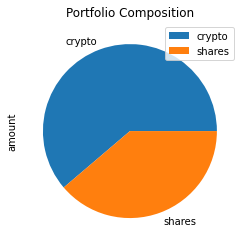

In [12]:
# Plot savings pie chart
df_savings.plot.pie(y="amount", title="Portfolio Composition");

In [13]:
# Set ideal emergency fund
emergency_fund = monthly_income * 3

# Calculate total amount of savings
cur_savings = crypto + shares
cur_savings

# Validate saving health
if cur_savings < emergency_fund:
    print(f"Keep up your good work.  You are only ${emergency_fund - cur_savings :0.2f} away from reaching your Emergency Fund goal.")
elif cur_savings == emergency_fund:
    print(f"Congratulations! You have reached your Emergency Fund financial goal!")
else:
    print(f"Congratulations! You have enough money in your Emergency Fund!")
          

Congratulations! You have enough money in your Emergency Fund!


## Part 2 - Retirement Planning

### Monte Carlo Simulation

In [14]:
# Set start and end dates of five years back from today.
# Sample results may vary from the solution based on the time frame chosen
start_date = pd.Timestamp('2017-04-10', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2022-04-10', tz='America/New_York').isoformat()

In [15]:
# Get 5 years' worth of historical data for SPY and AGG
# (use a limit=1000 parameter to call the most recent 1000 days of data)
df_stock_data = alpaca_api.get_bars(
    tickers,
    timeframe,
    start=start_date,
    end=end_date,
    limit=10000
).df

# Display sample data
df_stock_data.tail()

,open,high,low,close,volume,trade_count,vwap,symbol
timestamp,,,,,,,,
2022-04-04 04:00:00+00:00,453.20,456.91,452.26,456.80,59663209,503316,455.309774,SPY
2022-04-05 04:00:00+00:00,455.23,457.83,449.82,451.03,74022189,644313,453.412462,SPY
2022-04-06 04:00:00+00:00,446.87,448.93,443.47,446.52,105592595,901634,446.345270,SPY
2022-04-07 04:00:00+00:00,445.67,450.69,443.53,448.77,77538519,628673,447.098209,SPY
2022-04-08 04:00:00+00:00,448.04,450.63,445.94,447.57,79148376,573491,448.250805,SPY


In [16]:
# Reorganize the DataFrame
# Separate ticker data
AGG_sep = df_stock_data[df_stock_data["symbol"]=="AGG"].drop("symbol", axis=1)
SPY_sep = df_stock_data[df_stock_data["symbol"]=="SPY"].drop("symbol", axis=1)

# Concatenate the ticker DataFrames
df_stock_data = pd.concat([AGG_sep, SPY_sep], axis=1, keys=["AGG","SPY"])

# Display sample data
df_stock_data.head()

AGG                                     \
                             open    high       low   close   volume   
timestamp                                                              
2017-04-10 04:00:00+00:00  108.53  108.65  108.4901  108.58  1903768   
2017-04-11 04:00:00+00:00  108.79  108.98  108.7500  108.89  2200830   
2017-04-12 04:00:00+00:00  108.93  109.20  108.8900  109.13  2432965   
2017-04-13 04:00:00+00:00  109.25  109.39  109.1300  109.27  2339939   
2017-04-17 04:00:00+00:00  109.30  109.40  109.1800  109.21  1646056   

                                                      SPY                   \
                          trade_count        vwap    open     high     low   
timestamp                                                                    
2017-04-10 04:00:00+00:00       12236  108.566615  235.36  236.255  234.73   
2017-04-11 04:00:00+00:00       11420  108.874603  234.90  235.180  233.34   
2017-04-12 04:00:00+00:00       10372  109.013960  234.80  234.960  233.77   
2017-04-13 04:00:00+00:00       13465  109.262713  233.65  234.490  232.51   
2017-04-17 04:00:00+00:00        7973  109.294030  233.12  234.570  232.88   

                                                                     
                            close    volume trade_count        vwap  
timestamp                                                            
2017-04-10 04:00:00+00:00  235.34  67615302      211985  235.487358  
2017-04-11 04:00:00+00:00  235.06  88045276      306525  234.499802  
2017-04-12 04:00:00+00:00  234.03  81864436      262862  234.298297  
2017-04-13 04:00:00+00:00  232.51  92880394      303955  233.364725  
2017-04-17 04:00:00+00:00  234.57  68405367      213643  233.870859

In [17]:
# Configuring a Monte Carlo simulation to forecast 30 years cumulative returns
MC_40agg_60spy = MCSimulation(
    portfolio_data = df_stock_data,
    weights = [.40,.60],
    num_simulation = 500,
    num_trading_days = 252*30
    
)

In [18]:
# Print the simulation input data
MC_40agg_60spy.portfolio_data.head()

AGG                                     \
                             open    high       low   close   volume   
timestamp                                                              
2017-04-10 04:00:00+00:00  108.53  108.65  108.4901  108.58  1903768   
2017-04-11 04:00:00+00:00  108.79  108.98  108.7500  108.89  2200830   
2017-04-12 04:00:00+00:00  108.93  109.20  108.8900  109.13  2432965   
2017-04-13 04:00:00+00:00  109.25  109.39  109.1300  109.27  2339939   
2017-04-17 04:00:00+00:00  109.30  109.40  109.1800  109.21  1646056   

                                                                   SPY  \
                          trade_count        vwap daily_return    open   
timestamp                                                                
2017-04-10 04:00:00+00:00       12236  108.566615          NaN  235.36   
2017-04-11 04:00:00+00:00       11420  108.874603     0.002855  234.90   
2017-04-12 04:00:00+00:00       10372  109.013960     0.002204  234.80   
2017-04-13 04:00:00+00:00       13465  109.262713     0.001283  233.65   
2017-04-17 04:00:00+00:00        7973  109.294030    -0.000549  233.12   

                                                                          \
                              high     low   close    volume trade_count   
timestamp                                                                  
2017-04-10 04:00:00+00:00  236.255  234.73  235.34  67615302      211985   
2017-04-11 04:00:00+00:00  235.180  233.34  235.06  88045276      306525   
2017-04-12 04:00:00+00:00  234.960  233.77  234.03  81864436      262862   
2017-04-13 04:00:00+00:00  234.490  232.51  232.51  92880394      303955   
2017-04-17 04:00:00+00:00  234.570  232.88  234.57  68405367      213643   

                                                    
                                 vwap daily_return  
timestamp                                           
2017-04-10 04:00:00+00:00  235.487358          NaN  
2017-04-11 04:00:00+00:00  234.499802    -0.001190  
2017-04-12 04:00:00+00:00  234.298297    -0.004382  
2017-04-13 04:00:00+00:00  233.364725    -0.006495  
2017-04-17 04:00:00+00:00  233.870859     0.008860

In [19]:
# Running a Monte Carlo simulation to forecast 30 years cumulative returns
MC_40agg_60spy.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


C:\Users\scott\OneDrive\Scott\FinTechBC\InClassWork\ASU-VIRT-FIN-PT-03-2022-U-LOL\05-APIs\Homework\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.006270,1.011409,1.009894,1.015198,1.001223,1.009237,0.994617,0.998448,0.998667,0.995923,...,0.986655,1.003806,0.995532,1.001541,0.999878,0.990208,1.000921,1.012915,0.995624,0.994826
2,1.004934,1.009289,1.014273,1.001919,1.008202,1.017592,0.995338,0.997426,1.001856,1.010160,...,0.973943,1.008453,1.005026,1.000581,0.997409,0.988014,1.007639,1.006155,1.005173,0.985766
3,1.017483,1.013486,1.010321,1.020024,1.008755,1.020859,0.987571,0.989624,1.004681,1.015185,...,0.981554,1.010744,1.010335,0.999413,1.007635,0.988920,1.010730,1.000284,1.003178,0.988844
4,1.011950,1.018785,1.015834,1.018348,1.004070,1.015054,0.985449,0.992930,1.004559,1.022343,...,0.991716,1.016222,1.011544,0.989946,1.018887,0.983095,1.028161,1.005086,1.011412,0.987810
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7556,4.239919,10.602615,12.063741,8.409495,9.364960,6.020227,19.901179,24.173441,2.895991,3.857677,...,2.030425,9.081723,12.057974,8.485222,14.313373,12.344504,1.502124,6.025638,12.496809,8.237664
7557,4.260189,10.576839,12.112564,8.458736,9.312381,6.063338,19.826683,24.438952,2.895821,3.886265,...,2.045190,9.144669,12.094582,8.533439,14.391865,12.299726,1.494291,6.072508,12.464221,8.247484
7558,4.238829,10.582028,12.090573,8.536126,9.338147,6.027704,20.110417,24.595799,2.947329,3.844449,...,2.050323,9.144022,12.001961,8.582629,14.371493,12.274699,1.478840,6.074313,12.618917,8.269733
7559,4.189772,10.659813,12.111030,8.599455,9.394588,6.014445,20.085603,24.384729,2.921323,3.866144,...,2.046780,9.210642,12.001494,8.646461,14.312751,12.235289,1.460150,6.029073,12.653296,8.331972


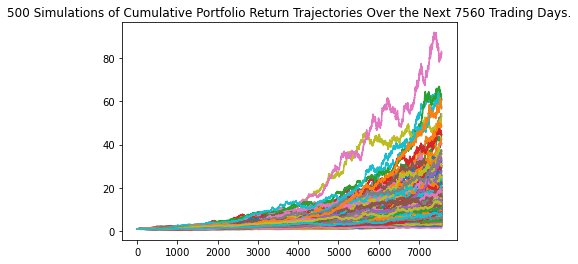

In [20]:
# Plot simulation outcomes
line_plot = MC_40agg_60spy.plot_simulation()

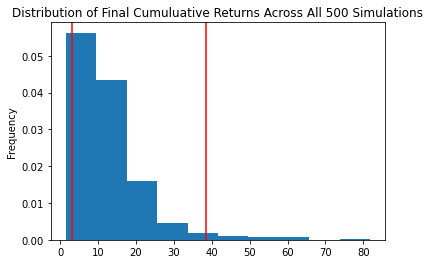

In [21]:
# Plot probability distribution and confidence intervals
dist_plot = MC_40agg_60spy.plot_distribution()

### Retirement Analysis

In [22]:
# Fetch summary statistics from the Monte Carlo simulation results
MC_40agg_60spy_tbl = MC_40agg_60spy.summarize_cumulative_return()

# Print summary statistics
print(MC_40agg_60spy_tbl)

count           500.000000
mean             12.876649
std               9.602839
min               1.450216
25%               6.838875
50%              10.715356
75%              15.651155
max              81.807319
95% CI Lower      3.067445
95% CI Upper     38.549903
Name: 7560, dtype: float64


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `$20,000` initial investment.

In [23]:
# Set initial investment
initial_investment = 20000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $20,000
ci_lower = round(MC_40agg_60spy_tbl[8]*initial_investment,2)
ci_upper = round(MC_40agg_60spy_tbl[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $20000 in the portfolio over the next 30 years will end within in the range of $61348.91 and $770998.05


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `50%` increase in the initial investment.

In [24]:
# Set initial investment
initial_investment = 20000 * 1.5

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $30,000
ci_lower = round(MC_40agg_60spy_tbl[8]*initial_investment,2)
ci_upper = round(MC_40agg_60spy_tbl[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $30000.0 in the portfolio over the next 30 years will end within in the range of $92023.36 and $1156497.08


## Optional Challenge - Early Retirement


### Five Years Retirement Option

In [25]:
# Configuring a Monte Carlo simulation to forecast 5 years cumulative returns
# Want to minimize risk since you would like to retire in 5 years - assumption is 30% stocks (SPY)
# Initial investment will need to be much higher - assumption is 2.5mm.
MC_70agg_30spy = MCSimulation(
    portfolio_data = df_stock_data,
    weights = [.70,.30],
    num_simulation = 500,
    num_trading_days = 252*5
)

In [26]:
# Running a Monte Carlo simulation to forecast 5 years cumulative returns
MC_70agg_30spy.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


C:\Users\scott\OneDrive\Scott\FinTechBC\InClassWork\ASU-VIRT-FIN-PT-03-2022-U-LOL\05-APIs\Homework\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.994957,1.000829,0.996521,0.997806,1.002861,1.003742,0.999101,0.998528,1.004497,0.999280,...,0.992590,0.998180,1.000024,1.000143,1.000071,0.996636,1.005135,1.003948,0.996882,0.996799
2,0.987140,0.995934,0.996702,1.000632,1.006637,1.008578,1.004848,1.000002,1.003628,1.000436,...,0.995034,0.999527,1.001669,0.999584,0.993158,1.000745,1.005122,1.005973,0.998583,1.001611
3,0.988874,0.997390,1.001280,1.002360,1.001476,1.007024,1.005606,0.997398,1.001403,0.999916,...,0.995642,1.006269,0.996918,1.003321,0.997912,0.994419,1.008403,1.000745,0.995446,0.991657
4,0.985576,0.997206,0.999937,1.001007,0.992629,1.001315,1.003186,1.003682,1.001413,1.002078,...,1.001365,1.006950,0.996798,1.011053,1.000984,0.997391,1.007726,0.999277,0.996158,0.994254
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,1.383196,0.937373,1.030329,1.057232,1.153962,1.213568,1.450616,1.947100,1.013681,1.177363,...,1.416515,0.953327,1.174432,1.358283,1.618634,1.135927,1.492252,1.359692,1.349288,1.134069
1257,1.387176,0.940345,1.030206,1.061466,1.157675,1.219957,1.455769,1.952674,1.009114,1.181814,...,1.417042,0.955114,1.171774,1.358630,1.614477,1.131421,1.505327,1.364272,1.345292,1.133283
1258,1.389865,0.947234,1.037811,1.062704,1.151966,1.223912,1.459431,1.962367,1.010989,1.181907,...,1.402800,0.955166,1.171979,1.362481,1.621138,1.124901,1.505384,1.372365,1.340409,1.128726
1259,1.391405,0.944419,1.041846,1.061283,1.154491,1.213738,1.461455,1.959446,1.013209,1.182150,...,1.398526,0.957273,1.179301,1.365721,1.624416,1.132627,1.510774,1.370392,1.333701,1.128457


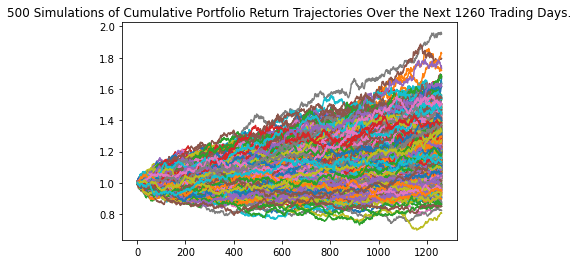

In [27]:
# Plot simulation outcomes
line_plot = MC_70agg_30spy.plot_simulation()

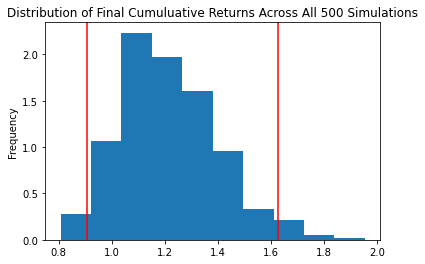

In [28]:
# Plot probability distribution and confidence intervals
dist_plot = MC_70agg_30spy.plot_distribution()

In [29]:
# Fetch summary statistics from the Monte Carlo simulation results
MC_70agg_30spy_tbl = MC_70agg_30spy.summarize_cumulative_return()

# Print summary statistics
print(MC_70agg_30spy_tbl)

count           500.000000
mean              1.214105
std               0.181948
min               0.807231
25%               1.084704
50%               1.198112
75%               1.321732
max               1.952822
95% CI Lower      0.906125
95% CI Upper      1.626892
Name: 1260, dtype: float64


In [30]:
# Set initial investment
initial_investment = 2500000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $20,000
ci_lower_five = round(MC_70agg_30spy_tbl[8]*initial_investment,2)
ci_upper_five = round(MC_70agg_30spy_tbl[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${ci_lower_five} and ${ci_upper_five}")

There is a 95% chance that an initial investment of $2500000 in the portfolio over the next 5 years will end within in the range of $2265313.48 and $4067229.72


### Ten Years Retirement Option

In [31]:
# Configuring a Monte Carlo simulation to forecast 10 years cumulative returns
# We have 10 years to retire, so we will take more risk - assumption is 70% stocks (SPY)
# Initial investment will need to be much higher - assumption is 1.5mm.
MC_30agg_70spy = MCSimulation(
    portfolio_data = df_stock_data,
    weights = [.30,.70],
    num_simulation = 500,
    num_trading_days = 252*10
)

In [32]:
# Running a Monte Carlo simulation to forecast 10 years cumulative returns
MC_30agg_70spy.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


C:\Users\scott\OneDrive\Scott\FinTechBC\InClassWork\ASU-VIRT-FIN-PT-03-2022-U-LOL\05-APIs\Homework\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.002232,1.000891,0.990058,0.991358,1.007643,0.989494,1.003141,1.004203,0.993766,0.996088,...,0.990422,0.990565,1.000504,0.994029,0.999530,0.999124,1.008763,0.998148,1.007395,0.999628
2,0.997095,0.999929,0.997152,1.011631,1.004941,0.983662,1.003235,1.011819,0.983301,0.992978,...,0.997820,0.987068,1.024033,0.992504,0.990641,1.002184,1.004353,1.004379,1.003725,1.005531
3,1.002030,0.985776,0.996428,1.001869,1.007532,0.992515,1.023285,1.014949,0.994014,0.989289,...,0.992306,0.999798,1.026550,1.005106,0.985090,1.012879,0.988081,0.999212,0.997576,0.996186
4,0.993618,0.968134,0.991873,1.000838,1.010747,1.005992,1.032536,1.025689,1.005613,1.000315,...,0.987424,0.991609,1.032513,1.007655,0.985307,1.029544,0.988788,0.991918,1.009653,0.994770
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2516,1.629399,1.774974,3.644184,2.255963,1.781810,2.704313,1.854038,2.693777,3.494347,3.410613,...,1.209810,2.706815,2.480974,4.098043,0.844612,3.020694,2.971707,3.538555,1.690187,2.621204
2517,1.634341,1.783254,3.598474,2.259141,1.795953,2.732021,1.872873,2.685627,3.496571,3.462701,...,1.193174,2.752702,2.497858,4.045395,0.850353,3.004870,3.016649,3.515447,1.688974,2.617224
2518,1.647550,1.800226,3.575765,2.270906,1.814003,2.728719,1.904697,2.657602,3.488159,3.480134,...,1.202784,2.797199,2.522286,4.003924,0.851914,3.016885,3.026527,3.493511,1.698031,2.626007
2519,1.638688,1.788750,3.516439,2.290762,1.815152,2.722665,1.913784,2.634387,3.562368,3.434138,...,1.206866,2.785584,2.522375,4.030991,0.847140,3.019220,3.067126,3.488170,1.700459,2.600054


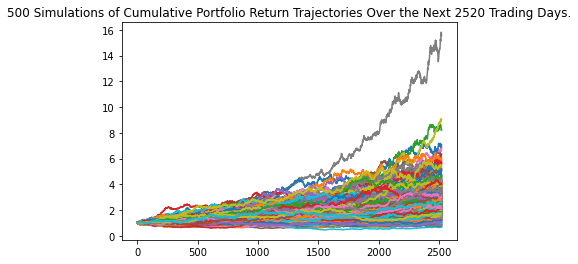

In [33]:
# Plot simulation outcomes
line_plot = MC_30agg_70spy.plot_simulation()

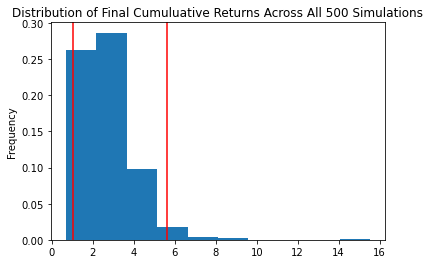

In [34]:
# Plot probability distribution and confidence intervals
dist_plot = MC_30agg_70spy.plot_distribution()

In [35]:
# Fetch summary statistics from the Monte Carlo simulation results
MC_30agg_70spy_tbl = MC_30agg_70spy.summarize_cumulative_return()

# Print summary statistics
print(MC_30agg_70spy_tbl)

count           500.000000
mean              2.713533
std               1.303005
min               0.679364
25%               1.870530
50%               2.484217
75%               3.329069
max              15.534666
95% CI Lower      1.017519
95% CI Upper      5.609179
Name: 2520, dtype: float64


In [36]:
# Set initial investment
initial_investment = 1500000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $20,000
ci_lower_ten = round(MC_30agg_70spy_tbl[8]*initial_investment,2)
ci_upper_ten = round(MC_30agg_70spy_tbl[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 10 years will end within in the range of"
      f" ${ci_lower_ten} and ${ci_upper_ten}")

There is a 95% chance that an initial investment of $1500000 in the portfolio over the next 10 years will end within in the range of $1526278.35 and $8413768.57
